In [1]:
import os
import json
import pandas as pd
import numpy as np
from scipy.fft import fft
import matplotlib.pyplot as plt

In [2]:
# Pembacaan Parameter Dataset
filename = "parameter.json"
with open(filename, 'r') as f:
    params = json.load(f)

In [3]:
# Function to read dataset.csv
def read_csv(filepath, row=True):
    df = pd.read_csv(filepath, header=None)
    if row: # row data
        data = df.T.values.tolist()[0]
    else: # comma-separated column data
        data = df.values.tolist()[0]
    return data
def read_raw(filepath):
    raw = []
    with open(filepath) as f:
        # read all lines into list of string
        lines = f.readlines()
        for line in lines:
            # remove leading and trailing white spaces and split by comma delimiter
            raw += line.strip().split(',')
    raw = [complex(s.replace('i', 'j')) for s in raw]
    return raw

In [4]:

# Read Data --------------------------------------------
# set dataset folder path
dataset_folder = 'F:\MATERI KULIAH\TESIS\REFERENSI\Children Dataset\Children Dataset'
radar_raw_folder = os.path.join(dataset_folder, "FMCW Radar\Rawdata")
radar_vital_folder = os.path.join(dataset_folder, "FMCW Radar\Heart Rate & Breathing Rate")
ref_raw_folder = os.path.join(dataset_folder, "Nihon Kohden\Heartbeat & Breathing Waveform")
ref_vital_folder = os.path.join(dataset_folder, "Nihon Kohden\Heart Rate & Breathing Rate")
subject_stats_folder = os.path.join(dataset_folder, "Participant\Human Data")
subject_photo_folder = os.path.join(dataset_folder, "Participant\Picture")

# Subjec
subject_id = 2
radar_raw_path = os.path.join(radar_raw_folder, f"Rawdata_{subject_id}.csv")
raw_data = read_raw(radar_raw_path)## Pemanggilan Dataset Dari Folder 
# Merubah data list ke Array 
raw_data = np.asarray(raw_data, dtype=complex)
n_samples = raw_data.shape[0]//params['n_rx']
# print(raw_data.shape[0])
raw_radar = raw_data.reshape(params['n_rx'],n_samples, order='C')
raw_new = raw_radar.reshape((params['n_rx'],params['n_adc']*params['n_chirp'],-1), order='F')
#read heart rate (HR) and breath rate (BR) reading from reference device
ref_hr_path = os.path.join(ref_vital_folder, f"Ref_Heart_{subject_id}.csv")
ref_br_path = os.path.join(ref_vital_folder, f"Ref_Breath_{subject_id}.csv")
# Radar Paper
# read heart rate (HR) and breath rate (BR) estimation from radar
hr_radar_path = os.path.join(radar_vital_folder, f"Heart_{subject_id}.csv")
br_radar_path = os.path.join(radar_vital_folder, f"Breath_{subject_id}.csv")
#df_radar = pd.read_csv(hr_radar_path, header=None)
hr_radar = read_csv(hr_radar_path, row=True)
br_radar = read_csv(br_radar_path, row=True)
#df_hr = pd.read_csv(ref_hr_path, header=None)
hr = read_csv(ref_hr_path, row=False)
br = read_csv(ref_br_path, row=False)
# Waveform 
radar_br_wave_path = os.path.join(ref_raw_folder, f"Ref_Breath_Wave_{subject_id}.csv")
radar_hr_wave_path = os.path.join(ref_raw_folder, f"Ref_Heart_Wave_{subject_id}.csv")
br_wave =np.array(read_csv(radar_br_wave_path))
hr_wave =np.array(read_csv(radar_hr_wave_path,row=True))

In [5]:
hr_radar = read_csv(hr_radar_path, row=True)
br_radar = read_csv(br_radar_path, row=True)
#df_hr = pd.read_csv(ref_hr_path, header=None)
hr = read_csv(ref_hr_path, row=False)
br = read_csv(ref_br_path, row=False)
# Waveform 
radar_br_wave_path = os.path.join(ref_raw_folder, f"Ref_Breath_Wave_{subject_id}.csv")
radar_hr_wave_path = os.path.join(ref_raw_folder, f"Ref_Heart_Wave_{subject_id}.csv")
br_wave =np.array(read_csv(radar_br_wave_path))
hr_wave =np.array(read_csv(radar_hr_wave_path,row=True))

In [6]:
def Range_FFT(InputData):
    OutputData = np.zeros((params['n_rx'], params['n_fft']//2, params['data_len']), dtype=complex)
    dc_removal = np.zeros((params['n_rx'], params['n_fft']//2, params['data_len']), dtype=complex)
    data_win = np.zeros((params['n_rx'], params['n_fft']//2, params['data_len']), dtype=complex)
    for i in range(params['n_rx']):
        for j in range(params['data_len']):
            window = np.hamming(params['n_fft'])
            dc_removal[i,:,j]= InputData[i,:,j] - np.mean(InputData[i,:,j])
            range_win = params['n_fft']//2
            data_win[i,:,j] = dc_removal[i,:,j] * range_win
            OutputData[i,:,j]= fft(data_win[i,:,j])
    return OutputData
    

In [7]:
def MTI(hasil_fft):
    clutter = np.zeros((hasil_fft.shape[0], params['n_fft']//2, hasil_fft.shape[-1]),dtype=complex)
    OutputData = np.zeros((hasil_fft.shape[0],params['n_fft']//2, hasil_fft.shape[-1]),dtype=complex)
    alpha = 0.01
    for i in np.arange(hasil_fft.shape[0]):
        for j in np.arange(1,hasil_fft.shape[-1]):
            clutter[i,:,j] = np.dot(alpha,hasil_fft[i,:,j])+ np.dot((1-alpha),clutter[i,:,j-1])
            OutputData[i,:,j] = hasil_fft[i,np.arange(params['n_fft']//2),j]-(clutter[i,range(0, params['n_fft']//2),j])
    return OutputData

In [8]:
Hasil_FFT = Range_FFT(raw_new)
Hasil_MTI = MTI(Hasil_FFT)

In [9]:
Hasil_MTI1 = Hasil_MTI[0,:,:]
Hasil_MTI2 = Hasil_MTI[1,:,:]
Hasil_MTI3 = Hasil_MTI[2,:,:]
Hasil_MTI4 = Hasil_MTI[3,:,:]
Hasil_MTI1.shape[1]

6000

In [10]:
def RangeBin(data):
    # Find Range-bin peaks
    rangeBinStartIndex = 5  # Resolution 0.1m
    rangeBinEndIndex = 25
    numFrame = data.shape[1]
    result = np.zeros((numFrame,), dtype=complex)  # Array for storing data peaks
    peak_index = []
    for k in range(1,numFrame):
        peakIndex = np.argmax(np.abs(data[rangeBinStartIndex:rangeBinEndIndex, k]))
        result[k] = data[rangeBinStartIndex + peakIndex, k]
        peak_index.append(rangeBinStartIndex + peakIndex)
    return result, peak_index

# Range Bin Selection

In [11]:
Range_Bin_An1,index1 = RangeBin(Hasil_MTI1)
Range_Bin_An2,index2 = RangeBin(Hasil_MTI2)
Range_Bin_An3,index3 = RangeBin(Hasil_MTI3)
Range_Bin_An4,index4 = RangeBin(Hasil_MTI4)
# Range_Bin_An2, index2

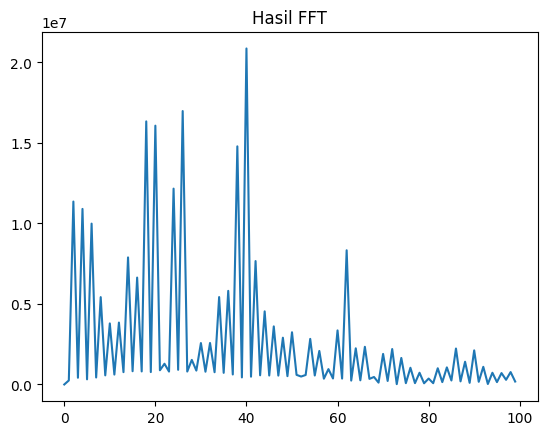

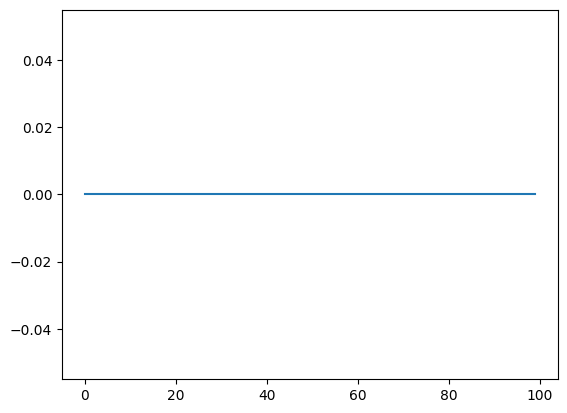

In [12]:
An1 = Hasil_FFT[0,:,:]
An2 = Hasil_FFT[1,:,:]
An3 = Hasil_FFT[2,:,:]
An4 = Hasil_FFT[3,:,:]
# 
Hasil_MTI1 = Hasil_MTI[0,:,:]
Hasil_MTI2 = Hasil_MTI[1,:,:]
Hasil_MTI3 = Hasil_MTI[2,:,:]
Hasil_MTI4 = Hasil_MTI[3,:,:]
plt.title("Hasil FFT")
col1 = An2[:,0]
col_mti_1 = Hasil_MTI2[:,0]
plt.figure(1)
plt.plot(abs(col1[:100]))
plt.figure(2)
plt.plot(abs(col_mti_1[:100]))

C:\Users\Asus\AppData\Local\Temp\ipykernel_2668\2741558634.py:7: RuntimeWarning: divide by zero encountered in log10
  20 * np.log10(np.abs(An1)),


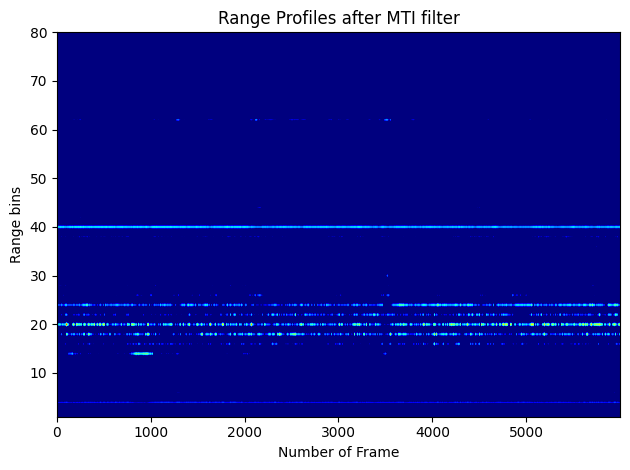

In [13]:
# Sample data
# Data_range_MTI = np.random.rand(60, 100)

# Plot the range profile
plt.figure()
img = plt.imshow(
    20 * np.log10(np.abs(An1)),
    cmap="jet",
    origin="lower",
    aspect="auto",
)

plt.xlabel("Number of Frame")
plt.ylabel("Range bins")

# Uncomment the line below if you want to add a title
plt.title('Range Profiles after MTI filter')

# Set y-axis limits
# plt.gca().set_ylim([1, 60])
# Set color limits
clim = img.get_clim()
plt.gca().set_ylim([1, 80])
# plt.gca().set_clim(clim[1] + [-60, 0])
# Set color limits using Option 1
# img.set_clim(clim[1] + [-60, 0])  # Option 2 using ScalarMappable
img.set_clim([clim[1] - 20, clim[1]])  # Adjusted the expression to match your intention

# plt.axis("off")

# Draw and show the plot
plt.draw()
plt.tight_layout()
plt.show()

C:\Users\Asus\AppData\Local\Temp\ipykernel_2668\1402307936.py:8: RuntimeWarning: divide by zero encountered in log10
  20 * np.log10(np.abs(Hasil_MTI2)),


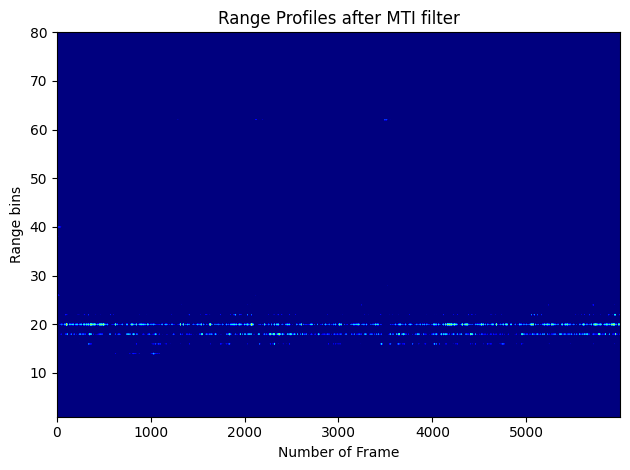

In [14]:
# Hasil_MTI1
# Sample data
# Data_range_MTI = np.random.rand(60, 100)

# Plot the range profile
plt.figure()
img = plt.imshow(
    20 * np.log10(np.abs(Hasil_MTI2)),
    cmap="jet",
    origin="lower",
    aspect="auto",
)

plt.xlabel("Number of Frame")
plt.ylabel("Range bins")

# Uncomment the line below if you want to add a title
plt.title('Range Profiles after MTI filter')

# Set y-axis limits
# plt.gca().set_ylim([1, 60])
# Set color limits
clim = img.get_clim()
plt.gca().set_ylim([1, 80])
# plt.gca().set_clim(clim[1] + [-60, 0])
# Set color limits using Option 1
# img.set_clim(clim[1] + [-60, 0])  # Option 2 using ScalarMappable
img.set_clim([clim[1] - 20, clim[1]])  # Adjusted the expression to match your intention

# plt.axis("off")

# Draw and show the plot
plt.draw()
plt.tight_layout()
plt.show()